In [ ]:
# train_dsb_mydata.py
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from dsb_tabular import DSBTabularBridge, set_seed

set_seed(0)

# 1) твои исходные данные X (np.ndarray [n_samples, d])
X = ...  # грузишь как хочешь

X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_z = scaler.transform(X_train)
X_val_z   = scaler.transform(X_val)

pca = PCA(whiten=True, svd_solver="full").fit(X_train_z)
X_train_w = pca.transform(X_train_z).astype(np.float32)
X_val_w   = pca.transform(X_val_z).astype(np.float32)

# 2) создаём мост
bridge = DSBTabularBridge(
    X_train_w,
    X_val_w,
    T=1.0,
    N=16,
    alpha_ou=1.0,
    lr=2e-3,
)

# 3) обучение
bridge.train(
    ipf_iters=5,
    steps_B=800,
    steps_F=800,
    batch=2048,
    pretrain_steps=300,
    pretrain_batch=1024,
)

# 4) оценка + сбор в переменные
res = bridge.evaluate(n_proj=512, sigma=1.0, steps_per_edge=3)

syn_train_w = res["syn_train_w"]
syn_val_w   = res.get("syn_val_w", None)

syn_train_orig = scaler.inverse_transform(pca.inverse_transform(syn_train_w))
syn_val_orig = None
if syn_val_w is not None:
    syn_val_orig = scaler.inverse_transform(pca.inverse_transform(syn_val_w))

swd_train = res["swd_train"]
mmd_train = res["mmd_train"]
ks_train  = res["ks_train"]

swd_val = res.get("swd_val", None)
mmd_val = res.get("mmd_val", None)
ks_val  = res.get("ks_val", None)

print(f"[FINAL] train SWD={swd_train:.5f}, MMD={mmd_train:.5f}")
if swd_val is not None:
    print(f"[FINAL]   val SWD={swd_val:.5f}, MMD={mmd_val:.5f}")


syn_train_w = bridge.sample_from_bridge(num=X_train_w.shape[0], steps_per_edge=3)

from dsb_tabular import sliced_wasserstein

swd_512   = sliced_wasserstein(X_train_w, syn_train_w, n_proj=512)
swd_4096  = sliced_wasserstein(X_train_w, syn_train_w, n_proj=4096)

print("SWD(512) =", swd_512)
print("SWD(4096) =", swd_4096)



TypeError: Input should have at least 1 dimension i.e. satisfy `len(x.shape) > 0`, got scalar `array(Ellipsis, dtype=object)` instead.

# OneHot на категории

In [ ]:
"""
run_dsb_benchmarks.py

Бенчмарк твоего DSBTabularBridge:

Synthetic:
  - 2D Gaussian mixture
  - Swiss Roll (2D проекция)
  - Two Moons (ещё один toy)

Real tabular:
  - Adult (Census Income)            [OpenML 'adult']
  - Law School Admissions            [OpenML 'law-school-admission-binary']
  - Covertype                        [sklearn.fetch_covtype]
  - Default Credit Card Clients      [OpenML 'default-of-credit-card-clients']

VQ-латенты:
  - Colored MNIST VQ (из .npy)
  - CelebA VQ латент-коды (из .npy)

Результат:
  all_results: dict[dataset_name] -> {...} c метриками и сэмплами.
"""

import numpy as np
import pandas as pd

from sklearn.datasets import (
    make_blobs,
    make_swiss_roll,
    make_moons,
    fetch_openml,
    fetch_covtype,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from dsb_tabular import DSBTabularBridge, set_seed


# ------------------ общие helpers ------------------ #

def prepare_numpy_X(
    X: np.ndarray,
    test_size: float = 0.2,
    random_state: int = 42,
    use_pca: bool = False,
    pca_whiten: bool = True,
    pca_components=None,
):
    """
    Для чисто числовых X (np.ndarray):
      - train/val split
      - StandardScaler
      - опционально PCA(whiten=True)
    Возвращает:
      X_train_w, X_val_w, scaler, pca
    """
    from sklearn.decomposition import PCA

    X = np.asarray(X, dtype=np.float32)
    X_train, X_val = train_test_split(
        X, test_size=test_size, random_state=random_state
    )

    scaler = StandardScaler().fit(X_train)
    X_train_z = scaler.transform(X_train)
    X_val_z = scaler.transform(X_val)

    if use_pca:
        pca = PCA(
            whiten=pca_whiten,
            n_components=pca_components,
            svd_solver="full",
        ).fit(X_train_z)
        X_train_w = pca.transform(X_train_z).astype(np.float32)
        X_val_w = pca.transform(X_val_z).astype(np.float32)
    else:
        pca = None
        X_train_w = X_train_z.astype(np.float32)
        X_val_w = X_val_z.astype(np.float32)

    return X_train_w, X_val_w, scaler, pca


def prepare_mixed_df_to_matrix(
    X_df: pd.DataFrame,
    test_size: float = 0.2,
    random_state: int = 42,
    use_pca: bool = False,
    pca_whiten: bool = True,
    pca_components=None,
):
    """
    Для табличных данных с числовыми + категориальными фичами:
      - train/val split по строкам DataFrame
      - ColumnTransformer: num -> passthrough, cat -> OneHotEncoder
      - на полученную плотную матрицу: StandardScaler
      - опционально PCA

    Возвращает:
      X_train_w, X_val_w, col_transformer, scaler, pca
    """
    from sklearn.decomposition import PCA

    # train/val split по строкам
    X_train_df, X_val_df = train_test_split(
        X_df, test_size=test_size, random_state=random_state
    )

    # Разделяем числовые и категориальные колонки
    num_cols = X_df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X_df.columns if c not in num_cols]

    transformers = []
    if num_cols:
        transformers.append(("num", "passthrough", num_cols))
    if cat_cols:
        transformers.append(
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
        )

    col_transformer = ColumnTransformer(transformers)

    X_train_all = col_transformer.fit_transform(X_train_df)
    X_val_all = col_transformer.transform(X_val_df)

    # OneHotEncoder даёт sparse, приводим к dense
    if not isinstance(X_train_all, np.ndarray):
        X_train_all = X_train_all.toarray()
        X_val_all = X_val_all.toarray()

    # Глобальный StandardScaler
    scaler = StandardScaler().fit(X_train_all)
    X_train_z = scaler.transform(X_train_all)
    X_val_z = scaler.transform(X_val_all)

    if use_pca:
        pca = PCA(
            whiten=pca_whiten,
            n_components=pca_components,
            svd_solver="full",
        ).fit(X_train_z)
        X_train_w = pca.transform(X_train_z).astype(np.float32)
        X_val_w = pca.transform(X_val_z).astype(np.float32)
    else:
        pca = None
        X_train_w = X_train_z.astype(np.float32)
        X_val_w = X_val_z.astype(np.float32)

    return X_train_w, X_val_w, col_transformer, scaler, pca


def run_dsb_on_matrix(
    name: str,
    X_train_w: np.ndarray,
    X_val_w: np.ndarray,
    dsb_kwargs: dict | None = None,
    train_kwargs: dict | None = None,
    eval_kwargs: dict | None = None,
):
    """
    Унифицированный запуск DSBTabularBridge на уже подготовленной матрице.
    Возвращает словарь с метриками и сэмплами.
    """
    dsb_kwargs = dsb_kwargs or {}
    train_kwargs = train_kwargs or {}
    eval_kwargs = eval_kwargs or {}

    bridge = DSBTabularBridge(
        X_train_w=X_train_w,
        X_val_w=X_val_w,
        **dsb_kwargs,
    )

    bridge.train(**train_kwargs)

    eval_res = bridge.evaluate(**eval_kwargs)

    metrics = {
        "train": {
            "swd": eval_res["swd_train"],
            "mmd": eval_res["mmd_train"],
            "ks": eval_res["ks_train"],
        },
        "val": {
            "swd": eval_res.get("swd_val"),
            "mmd": eval_res.get("mmd_val"),
            "ks": eval_res.get("ks_val"),
        },
    }

    # Можно хранить сэмплы в whiten-пространстве
    syn = {
        "train_w": eval_res["syn_train_w"],
        "val_w": eval_res.get("syn_val_w"),
    }

    return {
        "name": name,
        "bridge": bridge,
        "metrics": metrics,
        "syn": syn,
    }


# ------------------ loaders под конкретные датасеты ------------------ #

def load_synth_gaussian_mixture(n_samples=20000, random_state=0):
    X, y = make_blobs(
        n_samples=n_samples,
        centers=4,
        n_features=2,
        cluster_std=1.0,
        random_state=random_state,
    )
    return X.astype(np.float32)


def load_synth_swiss_roll_2d(n_samples=20000, random_state=0):
    X3d, t = make_swiss_roll(
        n_samples=n_samples,
        noise=0.1,
        random_state=random_state,
    )
    # Берём (x, z) как 2D-проекцию
    X2d = X3d[:, [0, 2]]
    return X2d.astype(np.float32)


def load_synth_two_moons(n_samples=20000, random_state=0):
    X, y = make_moons(
        n_samples=n_samples,
        noise=0.1,
        random_state=random_state,
    )
    return X.astype(np.float32)


def load_adult_df():
    """
    Adult / Census Income.
    Берём фичи как DataFrame, target не нужен для DSB.
    """
    adult = fetch_openml("adult", as_frame=True)
    X_df = adult.data   # все 14 признаков
    return X_df


def load_law_school_df():
    """
    Law School Admissions (binarized).
    """
    ds = fetch_openml("law-school-admission-binary", as_frame=True)
    X_df = ds.data
    return X_df


def load_default_credit_card_df():
    """
    Default of Credit Card Clients.
    Через OpenML (dataset name может понадобиться поправить, если версия другая).
    """
    ds = fetch_openml("default-of-credit-card-clients", as_frame=True)
    X_df = ds.data
    return X_df


def load_covertype_X():
    """
    Covertype: все фичи числовые, можно работать как с np.ndarray.
    """
    cov = fetch_covtype(as_frame=False)
    X = cov.data
    return X.astype(np.float32)


def load_colored_mnist_vq(path: str):
    """
    Загрузка VQ-латентов для Colored MNIST.
    Ожидается npy файл формы [n_samples, d].
    """
    X = np.load(path)
    return X.astype(np.float32)


def load_celeba_vq(path: str):
    """
    Загрузка латент-кодов (например, VQ-VAE) для CelebA.
    """
    X = np.load(path)
    return X.astype(np.float32)


# ------------------ основной сценарий ------------------ #

def main():
    set_seed(0)

    # общие гиперпараметры DSB (можешь подправить по ходу экспериментов)
    DSB_CFG = dict(
        T=1.0,
        N=16,
        alpha_ou=1.0,
        lr=2e-3,
    )

    TRAIN_CFG = dict(
        ipf_iters=3,
        steps_B=400,
        steps_F=400,
        batch=4096,
        pretrain_steps=200,
        pretrain_batch=1024,
        print_swd=True,
    )

    EVAL_CFG = dict(
        n_proj=512,
        sigma=1.0,
        steps_per_edge=3,
    )

    all_results = {}

    # ---------- 1. Synthetic: 2D Gaussian mixture ----------
    X_gm = load_synth_gaussian_mixture()
    X_train_w, X_val_w, scaler_gm, pca_gm = prepare_numpy_X(
        X_gm, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["gaussian_mixture_2d"] = run_dsb_on_matrix(
        "gaussian_mixture_2d",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 2. Synthetic: Swiss Roll ----------
    X_sr = load_synth_swiss_roll_2d()
    X_train_w, X_val_w, scaler_sr, pca_sr = prepare_numpy_X(
        X_sr, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["swiss_roll_2d"] = run_dsb_on_matrix(
        "swiss_roll_2d",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 3. Synthetic: Two Moons ----------
    X_moons = load_synth_two_moons()
    X_train_w, X_val_w, scaler_m, pca_m = prepare_numpy_X(
        X_moons, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["two_moons"] = run_dsb_on_matrix(
        "two_moons",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 4. Adult (Census Income) ----------
    X_adult_df = load_adult_df()
    X_train_w, X_val_w, ct_adult, scaler_adult, pca_adult = prepare_mixed_df_to_matrix(
        X_adult_df,
        test_size=0.2,
        random_state=42,
        use_pca=False,   # можно включить при желании
    )
    all_results["adult"] = run_dsb_on_matrix(
        "adult",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 5. Law School ----------
    X_law_df = load_law_school_df()
    X_train_w, X_val_w, ct_law, scaler_law, pca_law = prepare_mixed_df_to_matrix(
        X_law_df,
        test_size=0.2,
        random_state=42,
        use_pca=False,
    )
    all_results["law_school"] = run_dsb_on_matrix(
        "law_school",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 6. Covertype ----------
    X_cov = load_covertype_X()
    # тут размер уже немаленький → можно включить PCA, если захочешь
    X_train_w, X_val_w, scaler_cov, pca_cov = prepare_numpy_X(
        X_cov,
        test_size=0.2,
        random_state=42,
        use_pca=False,
    )
    all_results["covertype"] = run_dsb_on_matrix(
        "covertype",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 7. Default Credit Card ----------
    X_def_df = load_default_credit_card_df()
    X_train_w, X_val_w, ct_def, scaler_def, pca_def = prepare_mixed_df_to_matrix(
        X_def_df,
        test_size=0.2,
        random_state=42,
        use_pca=False,
    )
    all_results["default_credit_card"] = run_dsb_on_matrix(
        "default_credit_card",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 8. VQ-версии изображений ----------
    # ЗДЕСЬ НУЖНО ПОДСТАВИТЬ свои пути к npy-файлам с латентами
    try:
        X_colored = load_colored_mnist_vq("colored_mnist_vq_codes.npy")
        X_train_w, X_val_w, scaler_cmnist, pca_cmnist = prepare_numpy_X(
            X_colored,
            test_size=0.2,
            random_state=42,
            use_pca=False,  # при очень большом D можно включить PCA
        )
        all_results["colored_mnist_vq"] = run_dsb_on_matrix(
            "colored_mnist_vq",
            X_train_w,
            X_val_w,
            dsb_kwargs=DSB_CFG,
            train_kwargs=TRAIN_CFG,
            eval_kwargs=EVAL_CFG,
        )
    except FileNotFoundError:
        print("WARN: colored_mnist_vq_codes.npy не найден — пропускаем этот эксперимент")

    try:
        X_celeba = load_celeba_vq("celeba_vq_latents.npy")
        X_train_w, X_val_w, scaler_celeba, pca_celeba = prepare_numpy_X(
            X_celeba,
            test_size=0.2,
            random_state=42,
            use_pca=False,
        )
        all_results["celeba_vq"] = run_dsb_on_matrix(
            "celeba_vq",
            X_train_w,
            X_val_w,
            dsb_kwargs=DSB_CFG,
            train_kwargs=TRAIN_CFG,
            eval_kwargs=EVAL_CFG,
        )
    except FileNotFoundError:
        print("WARN: celeba_vq_latents.npy не найден — пропускаем этот эксперимент")

    # Немного вывести summary по SWD
    for name, res in all_results.items():
        tr = res["metrics"]["train"]
        va = res["metrics"]["val"]
        print(
            f"{name:25s} | "
            f"train SWD={tr['swd']:.5f}, MMD={tr['mmd']:.5f} | "
            f"val SWD={va['swd']:.5f if va['swd'] is not None else float('nan'):.5f}"
        )

    return all_results


if __name__ == "__main__":
    all_results = main()


# Без категорий(выкидывем)

In [2]:
"""
run_dsb_benchmarks.py

Бенчмарк DSBTabularBridge на нескольких датасетах, ИСПОЛЬЗУЕМ ТОЛЬКО НЕПРЕРЫВНЫЕ
(числовые) ПРИЗНАКИ.

Datasets:

Synthetic:
  - 2D Gaussian mixture
  - Swiss Roll (2D projection)
  - Two Moons

Real tabular (only numeric columns):
  - Adult (Census Income)
  - Law School (Admission)
  - Covertype
  - Default Credit Card Clients

VQ-latents (numeric):
  - Colored MNIST VQ codes (npy)
  - CelebA VQ codes (npy)

Результат:
  all_results: dict[dataset_name] -> { "metrics": ..., "syn": ..., "bridge": ... }
"""

import numpy as np
import pandas as pd

from sklearn.datasets import (
    make_blobs,
    make_swiss_roll,
    make_moons,
    fetch_openml,
    fetch_covtype,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import importlib, dsb_tabular
importlib.reload(dsb_tabular)

from dsb_tabular import DSBTabularBridge, set_seed


# ------------------ helpers ------------------ #

def prepare_numpy_X(
    X: np.ndarray,
    test_size: float = 0.2,
    random_state: int = 42,
    use_pca: bool = False,
    pca_whiten: bool = True,
    pca_components=None,
):
    """
    Для чисто числовых X (np.ndarray):
      - train/val split
      - StandardScaler
      - опционально PCA(whiten=True)
    Возвращает:
      X_train_w, X_val_w, scaler, pca
    """
    from sklearn.decomposition import PCA

    X = np.asarray(X, dtype=np.float32)
    X_train, X_val = train_test_split(
        X, test_size=test_size, random_state=random_state
    )

    scaler = StandardScaler().fit(X_train)
    X_train_z = scaler.transform(X_train)
    X_val_z = scaler.transform(X_val)

    if use_pca:
        pca = PCA(
            whiten=pca_whiten,
            n_components=pca_components,
            svd_solver="full",
        ).fit(X_train_z)
        X_train_w = pca.transform(X_train_z).astype(np.float32)
        X_val_w = pca.transform(X_val_z).astype(np.float32)
    else:
        pca = None
        X_train_w = X_train_z.astype(np.float32)
        X_val_w = X_val_z.astype(np.float32)

    return X_train_w, X_val_w, scaler, pca


def run_dsb_on_matrix(
    name: str,
    X_train_w: np.ndarray,
    X_val_w: np.ndarray,
    dsb_kwargs: dict | None = None,
    train_kwargs: dict | None = None,
    eval_kwargs: dict | None = None,
):
    """
    Унифицированный запуск DSBTabularBridge на уже подготовленной матрице.
    Возвращает словарь с метриками и сэмплами.
    """
    dsb_kwargs = dsb_kwargs or {}
    train_kwargs = train_kwargs or {}
    eval_kwargs = eval_kwargs or {}

    bridge = DSBTabularBridge(
        X_train_w=X_train_w,
        X_val_w=X_val_w,
        **dsb_kwargs,
    )

    bridge.train(**train_kwargs)

    eval_res = bridge.evaluate(**eval_kwargs)

    metrics = {
        "train": {
            "swd": eval_res["swd_train"],
            "mmd": eval_res["mmd_train"],
            "ks": eval_res["ks_train"],
        },
        "val": {
            "swd": eval_res.get("swd_val"),
            "mmd": eval_res.get("mmd_val"),
            "ks": eval_res.get("ks_val"),
        },
    }

    syn = {
        "train_w": eval_res["syn_train_w"],
        "val_w": eval_res.get("syn_val_w"),
    }

    return {
        "name": name,
        "bridge": bridge,
        "metrics": metrics,
        "syn": syn,
    }


# ------------------ loaders под конкретные датасеты ------------------ #

def load_synth_gaussian_mixture(n_samples=20000, random_state=0):
    X, y = make_blobs(
        n_samples=n_samples,
        centers=4,
        n_features=2,
        cluster_std=1.0,
        random_state=random_state,
    )
    return X.astype(np.float32)


def load_synth_swiss_roll_2d(n_samples=20000, random_state=0):
    X3d, t = make_swiss_roll(
        n_samples=n_samples,
        noise=0.1,
        random_state=random_state,
    )
    X2d = X3d[:, [0, 2]]  # (x, z)
    return X2d.astype(np.float32)


def load_synth_two_moons(n_samples=20000, random_state=0):
    X, y = make_moons(
        n_samples=n_samples,
        noise=0.1,
        random_state=random_state,
    )
    return X.astype(np.float32)


def load_adult_numeric():
    """
    Adult / Census Income.
    Берём ТОЛЬКО числовые признаки.
    """
    adult = fetch_openml("adult", as_frame=True)
    X_df: pd.DataFrame = adult.data
    X_num = X_df.select_dtypes(include=[np.number])
    return X_num.values.astype(np.float32)


def load_law_school_numeric():
    """
    Law School Admissions.
    Берём ТОЛЬКО числовые признаки.
    """
    ds = fetch_openml("law-school-admission-binary", as_frame=True)
    X_df: pd.DataFrame = ds.data
    X_num = X_df.select_dtypes(include=[np.number])
    return X_num.values.astype(np.float32)


def load_default_credit_card_numeric():
    """
    Default of Credit Card Clients.
    Берём ТОЛЬКО числовые признаки.
    (В этом датасете большинство колонок уже числовые.)
    """
    ds = fetch_openml("default-of-credit-card-clients", as_frame=True)
    X_df: pd.DataFrame = ds.data
    X_num = X_df.select_dtypes(include=[np.number])
    return X_num.values.astype(np.float32)


def load_covertype_X():
    """
    Covertype: все фичи числовые (continuous + бинарные).
    Используем как есть.
    """
    cov = fetch_covtype(as_frame=False)
    X = cov.data
    return X.astype(np.float32)


def load_colored_mnist_vq(path: str):
    """
    VQ-латенты для Colored MNIST.
    Ожидается npy: [n_samples, d], float или int.
    """
    X = np.load(path)
    return X.astype(np.float32)


def load_celeba_vq(path: str):
    """
    VQ-латенты для CelebA.
    """
    X = np.load(path)
    return X.astype(np.float32)


# ------------------ основной сценарий ------------------ #

def main():
    set_seed(0)

    # Общие гиперпараметры DSB / train / eval
    DSB_CFG = dict(
        T=1.0,
        N=16,
        alpha_ou=1.0,
        lr=2e-3,
    )

    TRAIN_CFG = dict(
        ipf_iters=3,
        steps_B=300,
        steps_F=300,
        batch=4096,
        pretrain_steps=200,
        pretrain_batch=1024,
        print_swd=True,
    )

    EVAL_CFG = dict(
        n_proj=512,
        sigma=1.0,
        steps_per_edge=3,
        max_eval_samples=2500,   # <-- добавили
    )


    all_results = {}

    # ---------- 1. Gaussian mixture 2D ----------
    X_gm = load_synth_gaussian_mixture()
    X_train_w, X_val_w, scaler_gm, pca_gm = prepare_numpy_X(
        X_gm, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["gaussian_mixture_2d"] = run_dsb_on_matrix(
        "gaussian_mixture_2d",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 2. Swiss Roll 2D ----------
    X_sr = load_synth_swiss_roll_2d()
    X_train_w, X_val_w, scaler_sr, pca_sr = prepare_numpy_X(
        X_sr, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["swiss_roll_2d"] = run_dsb_on_matrix(
        "swiss_roll_2d",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 3. Two Moons ----------
    X_moons = load_synth_two_moons()
    X_train_w, X_val_w, scaler_m, pca_m = prepare_numpy_X(
        X_moons, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["two_moons"] = run_dsb_on_matrix(
        "two_moons",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

    # ---------- 4. Adult (only numeric) ----------
    X_adult = load_adult_numeric()
    X_train_w, X_val_w, scaler_adult, pca_adult = prepare_numpy_X(
        X_adult, test_size=0.2, random_state=42, use_pca=False
    )
    all_results["adult_numeric"] = run_dsb_on_matrix(
        "adult_numeric",
        X_train_w,
        X_val_w,
        dsb_kwargs=DSB_CFG,
        train_kwargs=TRAIN_CFG,
        eval_kwargs=EVAL_CFG,
    )

        # ---------- 5. Law School (only numeric) ----------
    try:
        X_law = load_law_school_numeric()
        X_train_w, X_val_w, scaler_law, pca_law = prepare_numpy_X(
            X_law, test_size=0.2, random_state=42, use_pca=False
        )
        all_results["law_school_numeric"] = run_dsb_on_matrix(
            "law_school_numeric",
            X_train_w,
            X_val_w,
            dsb_kwargs=DSB_CFG,
            train_kwargs=TRAIN_CFG,
            eval_kwargs=EVAL_CFG,
        )
    except Exception as e:
        print(
            f"WARN: Law School dataset is not available on OpenML, skipping. "
            f"Error: {e}"
        )


    # # ---------- 6. Covertype ----------
    # X_cov = load_covertype_X()
    # X_train_w, X_val_w, scaler_cov, pca_cov = prepare_numpy_X(
    #     X_cov, test_size=0.2, random_state=42, use_pca=False
    # )
    # all_results["covertype"] = run_dsb_on_matrix(
    #     "covertype",
    #     X_train_w,
    #     X_val_w,
    #     dsb_kwargs=DSB_CFG,
    #     train_kwargs=TRAIN_CFG,
    #     eval_kwargs=EVAL_CFG,
    # )

    # # ---------- 7. Default Credit Card (only numeric) ----------
    # X_def = load_default_credit_card_numeric()
    # X_train_w, X_val_w, scaler_def, pca_def = prepare_numpy_X(
    #     X_def, test_size=0.2, random_state=42, use_pca=False
    # )
    # all_results["default_credit_card_numeric"] = run_dsb_on_matrix(
    #     "default_credit_card_numeric",
    #     X_train_w,
    #     X_val_w,
    #     dsb_kwargs=DSB_CFG,
    #     train_kwargs=TRAIN_CFG,
    #     eval_kwargs=EVAL_CFG,
    # )

    # # ---------- 8. VQ-латенты (Colored MNIST, CelebA) ----------
    # # здесь подставь реальные пути к своим npy-файлам
    # try:
    #     X_colored = load_colored_mnist_vq("colored_mnist_vq_codes.npy")
    #     X_train_w, X_val_w, scaler_cmnist, pca_cmnist = prepare_numpy_X(
    #         X_colored, test_size=0.2, random_state=42, use_pca=False
    #     )
    #     all_results["colored_mnist_vq"] = run_dsb_on_matrix(
    #         "colored_mnist_vq",
    #         X_train_w,
    #         X_val_w,
    #         dsb_kwargs=DSB_CFG,
    #         train_kwargs=TRAIN_CFG,
    #         eval_kwargs=EVAL_CFG,
    #     )
    # except FileNotFoundError:
    #     print("WARN: colored_mnist_vq_codes.npy не найден — пропускаем")

    # try:
    #     X_celeba = load_celeba_vq("celeba_vq_latents.npy")
    #     X_train_w, X_val_w, scaler_celeba, pca_celeba = prepare_numpy_X(
    #         X_celeba, test_size=0.2, random_state=42, use_pca=False
    #     )
    #     all_results["celeba_vq"] = run_dsb_on_matrix(
    #         "celeba_vq",
    #         X_train_w,
    #         X_val_w,
    #         dsb_kwargs=DSB_CFG,
    #         train_kwargs=TRAIN_CFG,
    #         eval_kwargs=EVAL_CFG,
    #     )
    # except FileNotFoundError:
    #     print("WARN: celeba_vq_latents.npy не найден — пропускаем")

    # Краткий summary по SWD/MMD
    for name, res in all_results.items():
        tr = res["metrics"]["train"]
        va = res["metrics"]["val"]
        swd_val = va["swd"] if va["swd"] is not None else float("nan")
        mmd_val = va["mmd"] if va["mmd"] is not None else float("nan")
        print(
            f"{name:28s} | "
            f"train SWD={tr['swd']:.5f}, MMD={tr['mmd']:.5f} | "
            f"val SWD={swd_val:.5f}, MMD={mmd_val:.5f}"
        )

    return all_results

# if __name__ == "__main__":
all_results = main()

IPF 1/3 train F:  13%|█▎        | 39/300 [00:03<00:25, 10.35it/s]


KeyboardInterrupt: 

In [2]:
import joblib
from pathlib import Path

SAVE_PATH = "dsb_benchmark_results.pkl"

def safe_serialize_results(results):
    safe = {}
    for name, res in results.items():
        entry = {
            "name": res["name"],
            "metrics": res["metrics"],
            "syn": res["syn"],  # syn_train_w, syn_val_w — np.ndarray, joblib их хорошо сохранит
        }
        # Сохраняем scaler/pca (они лёгкие и нужны для inverse_transform)
        bridge = res["bridge"]
        entry["scaler"] = getattr(bridge, "scaler", None)
        entry["pca"] = getattr(bridge, "pca", None)
        # Если хочешь — можно ещё сохранить гиперпараметры модели, но не саму модель
        if hasattr(bridge, "model") and hasattr(bridge.model, "state_dict"):
            entry["model_state_dict_keys"] = list(bridge.model.state_dict().keys())
        safe[name] = entry
    return safe

print(f"\n💾 Сохраняю результаты в {SAVE_PATH}...")
joblib.dump(safe_serialize_results(all_results), SAVE_PATH, compress=3)
print("✅ Готово! Теперь можно загрузить позже через:\n"
      "   ```python\n"
      "   import joblib\n"
      "   all_results = joblib.load('dsb_benchmark_results.pkl')\n"
      "   ```")


💾 Сохраняю результаты в dsb_benchmark_results.pkl...
✅ Готово! Теперь можно загрузить позже через:
   ```python
   import joblib
   all_results = joblib.load('dsb_benchmark_results.pkl')
   ```


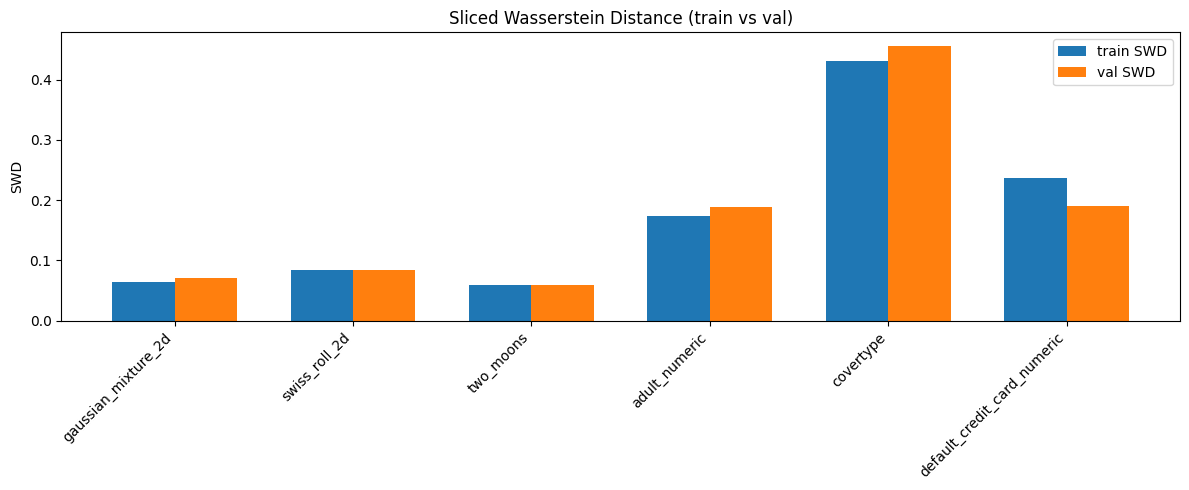

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Предполагаем, что all_results уже есть в памяти
dataset_names = list(all_results.keys())

train_swd = []
val_swd   = []

for name in dataset_names:
    m = all_results[name]["metrics"]
    train_swd.append(m["train"]["swd"])
    val_swd.append(m["val"]["swd"])   # может быть None, обработаем ниже

# Заменим None на np.nan, чтобы не ломало плаоты
val_swd = [np.nan if v is None else v for v in val_swd]

x = np.arange(len(dataset_names))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_swd, width, label="train SWD")
plt.bar(x + width/2, val_swd,   width, label="val SWD")

plt.xticks(x, dataset_names, rotation=45, ha="right")
plt.ylabel("SWD")
plt.title("Sliced Wasserstein Distance (train vs val)")
plt.legend()
plt.tight_layout()
plt.show()

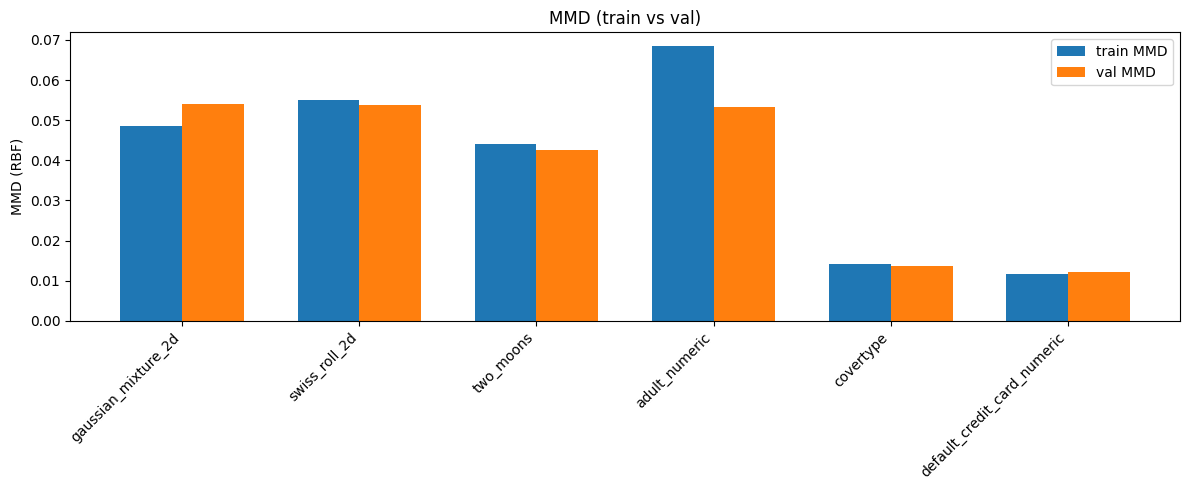

In [5]:
train_mmd = []
val_mmd   = []

for name in dataset_names:
    m = all_results[name]["metrics"]
    train_mmd.append(m["train"]["mmd"])
    val_mmd.append(m["val"]["mmd"])

val_mmd = [np.nan if v is None else v for v in val_mmd]

x = np.arange(len(dataset_names))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_mmd, width, label="train MMD")
plt.bar(x + width/2, val_mmd,   width, label="val MMD")

plt.xticks(x, dataset_names, rotation=45, ha="right")
plt.ylabel("MMD (RBF)")
plt.title("MMD (train vs val)")
plt.legend()
plt.tight_layout()
plt.show()


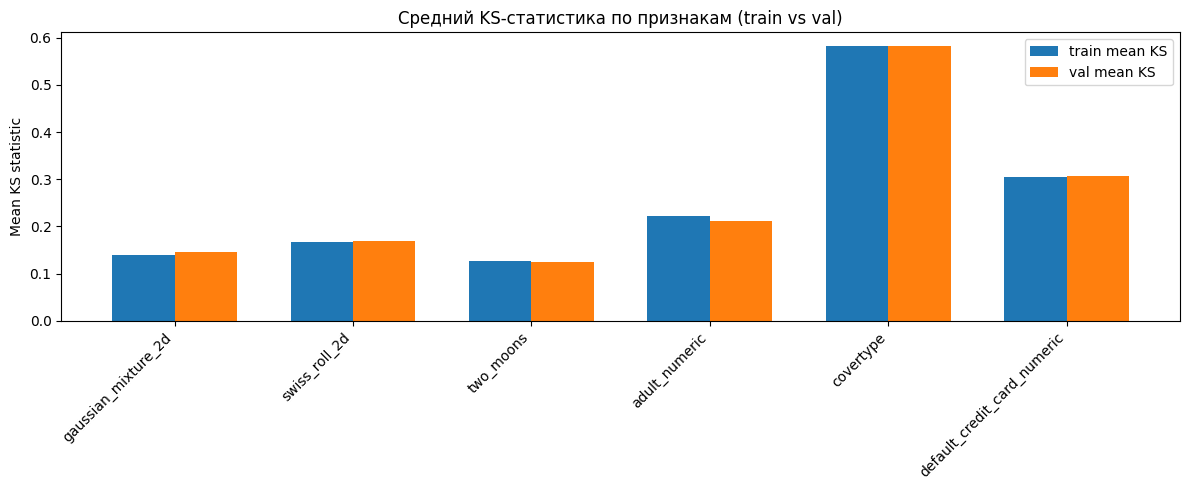

In [6]:
def mean_ks(ks_list):
    # ks_list: List[(j, ks_stat, p_value)]
    stats = [ks_stat for (_j, ks_stat, _p) in ks_list]
    return float(np.mean(stats)) if len(stats) > 0 else np.nan

train_ks_mean = []
val_ks_mean   = []

for name in dataset_names:
    m = all_results[name]["metrics"]

    ks_train = m["train"]["ks"]
    train_ks_mean.append(mean_ks(ks_train))

    ks_val = m["val"]["ks"]
    if ks_val is None:
        val_ks_mean.append(np.nan)
    else:
        val_ks_mean.append(mean_ks(ks_val))

x = np.arange(len(dataset_names))
width = 0.35

plt.figure(figsize=(12, 5))
plt.bar(x - width/2, train_ks_mean, width, label="train mean KS")
plt.bar(x + width/2, val_ks_mean,   width, label="val mean KS")

plt.xticks(x, dataset_names, rotation=45, ha="right")
plt.ylabel("Mean KS statistic")
plt.title("Средний KS-статистика по признакам (train vs val)")
plt.legend()
plt.tight_layout()
plt.show()


# Сравниваем с TabDDPM и CTGAN

In [1]:

import pickle
from eval_tabular_data import evaluate_models_on_datasets

with open(r"E:\projects\Diffusion_Sredinger_Bridge\data\real_data_dsb.pkl", "rb") as f:
    real_data = pickle.load(f)

with open(r"E:\projects\Diffusion_Sredinger_Bridge\data\synthetic_data_dsb (1).pkl", "rb") as f:
    syn_dsb = pickle.load(f)
with open(r"E:\projects\Diffusion_Sredinger_Bridge\data\synthetic_data_ctgan.pkl", "rb") as f:
    syn_ctgan = pickle.load(f)
with open(r"E:\projects\Diffusion_Sredinger_Bridge\data\synthetic_data_tabddpm.pkl", "rb") as f:
    syn_tabddpm = pickle.load(f)

synthetic_data = {}
synthetic_data.update(syn_dsb)       # "DSB"
synthetic_data.update(syn_ctgan)     # "CTGAN"
synthetic_data.update(syn_tabddpm)   # "TabDDPM"

metrics_all = evaluate_models_on_datasets(
    real_data=real_data,
    synthetic_data=synthetic_data,
    n_proj=512,
    sigma=1.0,
    max_eval_samples=2500,
    random_state=0,
    pkl_path="metrics_dsb_ctgan_tabddpm_tunned.pkl",
)


e:\projects\AI_challenge_new_MMM\.venv\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
e:\projects\AI_challenge_new_MMM\.venv\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [13]:
metrics_all

{'DSB': {'california_housing': {'n_real': 2500,
   'n_syn': 2500,
   'dim': 8,
   'swd': 0.13009396195411682,
   'mmd': 0.07450452446937561,
   'fidelity_uni': {'wasserstein': {'per_feature': [0.3217868788692402,
      0.30476190464273095,
      0.18700301917399337,
      0.5818081255639148,
      0.24384177476255,
      0.21661871131328342,
      0.3295787758721039,
      0.26459476012177763],
     'mean': 0.30624924378994933,
     'max': 0.5818081255639148},
    'ks': {'per_feature': [{'feature': 0,
       'ks': 0.1704,
       'p': 4.2408571940568674e-32},
      {'feature': 1, 'ks': 0.1428, 'p': 1.2287887879065174e-22},
      {'feature': 2, 'ks': 0.1416, 'p': 2.900480839527156e-22},
      {'feature': 3, 'ks': 0.7496, 'p': 0.0},
      {'feature': 4, 'ks': 0.0972, 'p': 1.069092560175187e-10},
      {'feature': 5, 'ks': 0.5644, 'p': 0.0},
      {'feature': 6, 'ks': 0.2268, 'p': 9.445266235969667e-57},
      {'feature': 7, 'ks': 0.2204, 'p': 1.3659503246107948e-53}],
     'mean_ks': 0.28

In [4]:
metrics_all.items()

dict_items([('DSB', {'california_housing': {'n_real': 2500, 'n_syn': 2500, 'dim': 8, 'swd': 0.10507329553365707, 'mmd': 0.019274122635014823, 'fidelity_uni': {'wasserstein': {'per_feature': [0.30704032494395506, 0.2662717230459675, 0.17130968088804802, 0.15667876000536496, 0.2160763603964472, 0.18755554832581373, 0.19114451491069048, 0.15458638518359513], 'mean': 0.20633291221248526, 'max': 0.30704032494395506}, 'ks': {'per_feature': [{'feature': 0, 'ks': 0.1784, 'p': 3.6909159437914094e-35}, {'feature': 1, 'ks': 0.1752, 'p': 6.433688875466537e-34}, {'feature': 2, 'ks': 0.102, 'p': 9.719233515077023e-12}, {'feature': 3, 'ks': 0.2272, 'p': 5.951010310993926e-57}, {'feature': 4, 'ks': 0.13, 'p': 8.012229188848672e-19}, {'feature': 5, 'ks': 0.5708, 'p': 0.0}, {'feature': 6, 'ks': 0.25, 'p': 5.387445845270239e-69}, {'feature': 7, 'ks': 0.112, 'p': 4.525620978111207e-14}], 'mean_ks': 0.2182, 'max_ks': 0.5708}, 'js_categorical': {'per_feature': [], 'mean': None, 'max': None}}, 'fidelity_dep'

               dataset  model       swd       mmd  wasserstein_mean   ks_mean  \
0   california_housing    DSB  0.105073  0.019274          0.206333  0.218200   
1             diabetes    DSB  0.086469  0.027741          0.282931  0.197753   
2  king_county_housing    DSB  3.784598  0.021979          0.303973  0.271318   
3        adult_numeric    DSB  0.028793  0.014974          0.267102  0.319545   
4   california_housing  CTGAN  0.023124  0.004572          0.089660  0.079350   

   corr_mae_offdiag  
0          0.129604  
1          0.131877  
2          0.330145  
3          0.078250  
4          0.077865  


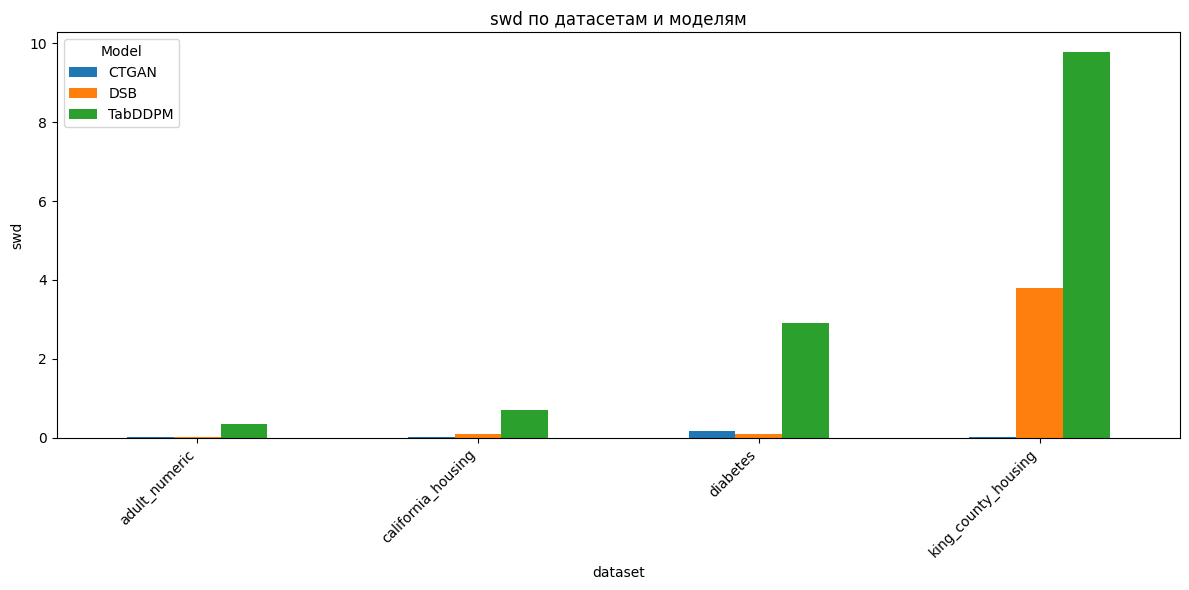

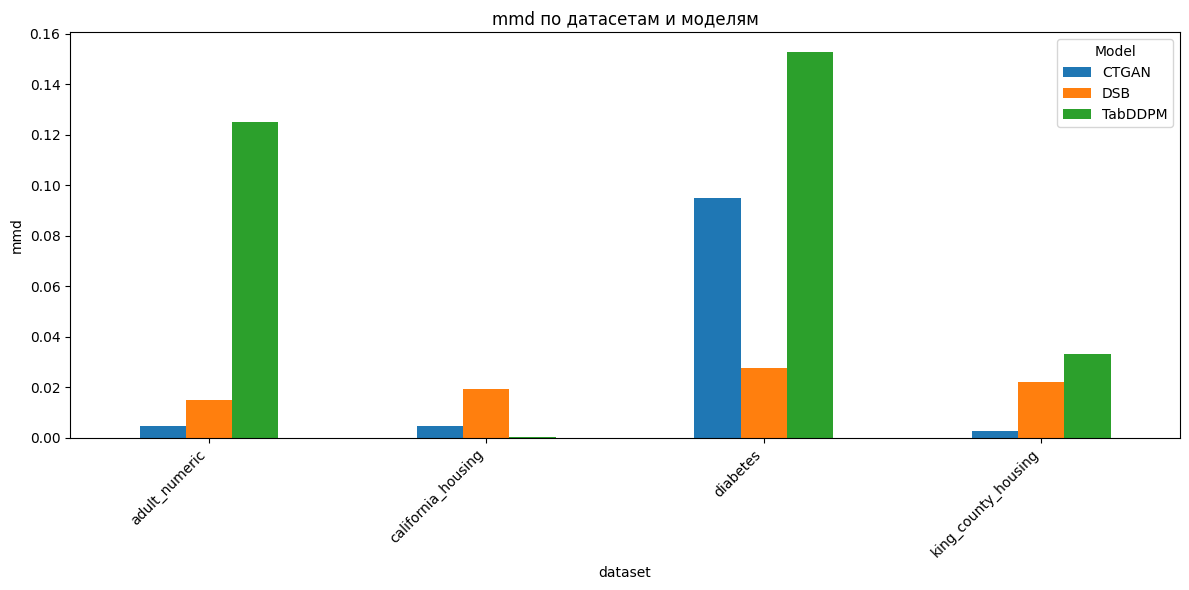

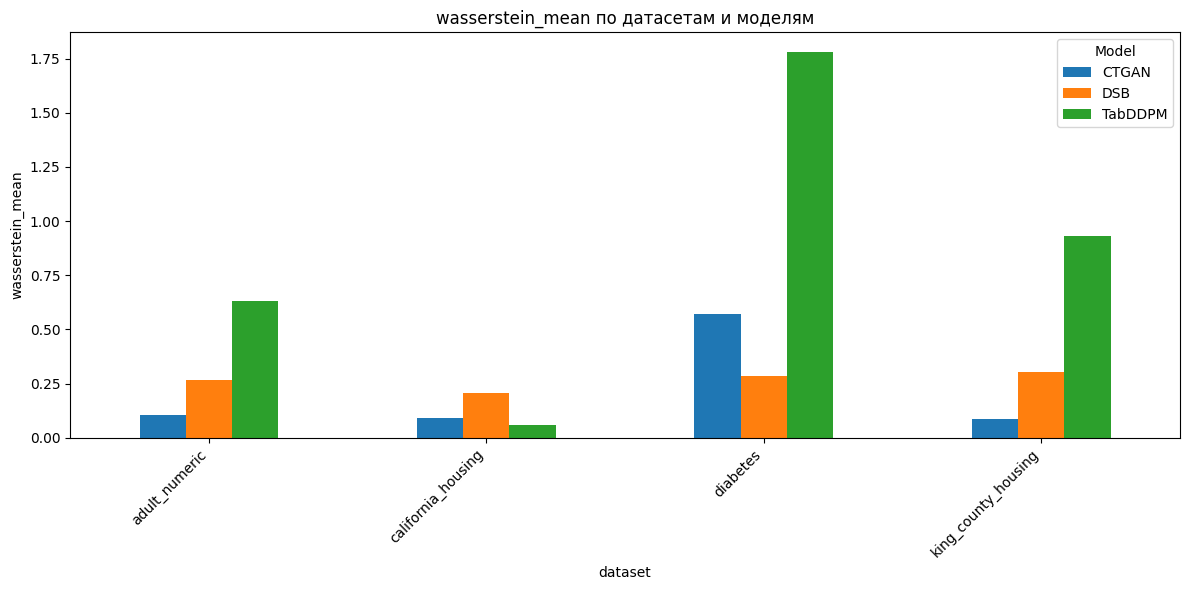

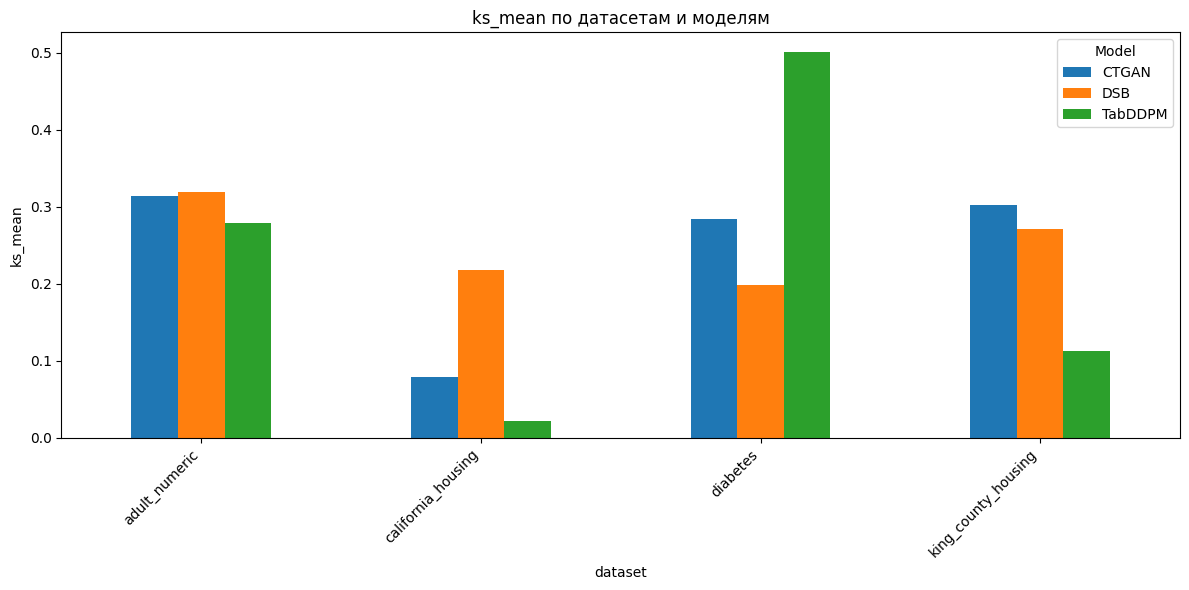

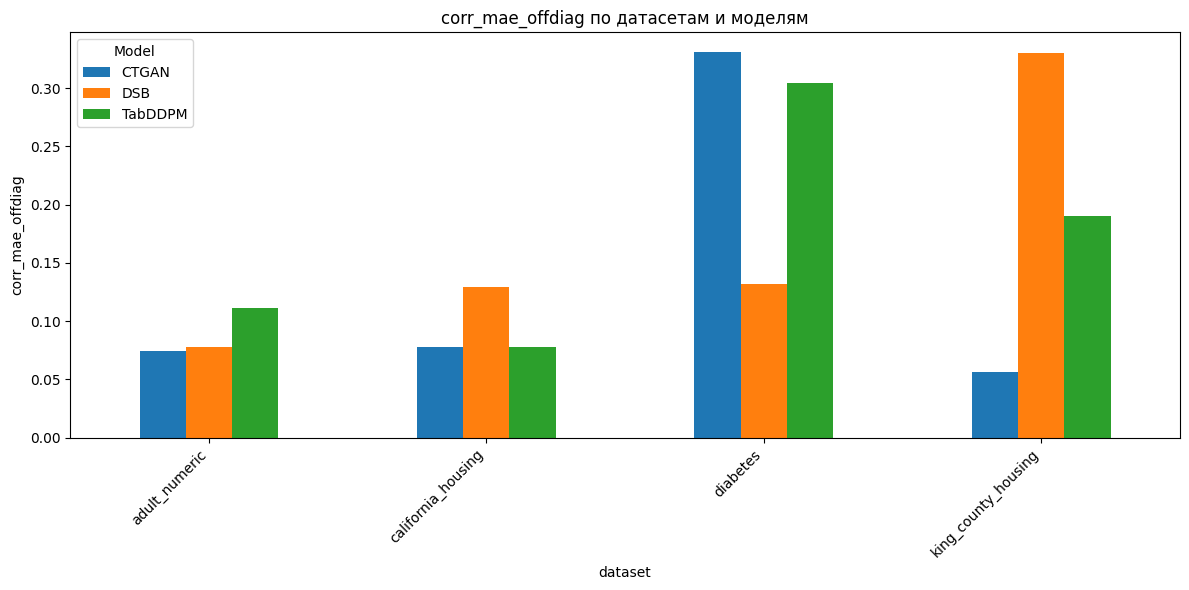

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- 1. Собираем метрики в таблицу -----------------

rows = []

for model_name, datasets_dict in metrics_all.items():
    for ds_name, vals in datasets_dict.items():
        if ds_name!='online_news_popularity':
            rows.append({
                "dataset": ds_name,
                "model": model_name,
                "swd": float(vals["swd"]) if vals.get("swd") is not None else None,
                "mmd": float(vals["mmd"]) if vals.get("mmd") is not None else None,
                "wasserstein_mean": float(vals["fidelity_uni"]["wasserstein"]["mean"]) if vals.get("fidelity_uni", {}).get("wasserstein", {}).get("mean") is not None else None,
                "ks_mean": float(vals["fidelity_uni"]["ks"]["mean_ks"]) if vals.get("fidelity_uni", {}).get("ks", {}).get("mean_ks") is not None else None,
                "corr_mae_offdiag": float(vals["fidelity_dep"]["corr_mae_offdiag"]) if vals.get("fidelity_dep", {}).get("corr_mae_offdiag") is not None else None,
            })

metrics_df = pd.DataFrame(rows)
print(metrics_df.head())

# ----------------- 2. Функция для построения barplot -----------------

def plot_metric_bar(df, metric: str):
    df_temp = df.copy()
    
    # приводим метрику к числу
    df_temp[metric] = pd.to_numeric(df_temp[metric], errors="coerce")
    
    # выбрасываем строки, где метрика не определена
    df_temp = df_temp.dropna(subset=[metric])
    
    if df_temp.empty:
        print(f"[WARN] Для metric='{metric}' нет числовых данных.")
        return
    
    # создаем сводную таблицу
    pivot = df_temp.pivot(index="dataset", columns="model", values=metric)
    
    # строим график
    ax = pivot.plot(kind="bar", figsize=(12, 6))
    ax.set_ylabel(metric)
    ax.set_title(f"{metric} по датасетам и моделям")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Model")
    plt.tight_layout()
    plt.show()

# ----------------- 3. Строим графики для разных метрик -----------------

plot_metric_bar(metrics_df, metric="swd")
plot_metric_bar(metrics_df, metric="mmd")
plot_metric_bar(metrics_df, metric="wasserstein_mean")
plot_metric_bar(metrics_df, metric="ks_mean")
plot_metric_bar(metrics_df, metric="corr_mae_offdiag")

               dataset    model  split       swd       mmd
0  gaussian_mixture_2d      DSB  train  0.059634  0.048802
1  gaussian_mixture_2d      DSB    val  0.065159  0.051221
2  gaussian_mixture_2d    CTGAN  train  0.003760  0.031836
3  gaussian_mixture_2d    CTGAN    val  0.004127  0.026476
4  gaussian_mixture_2d  TabDDPM  train  0.001050 -0.000032


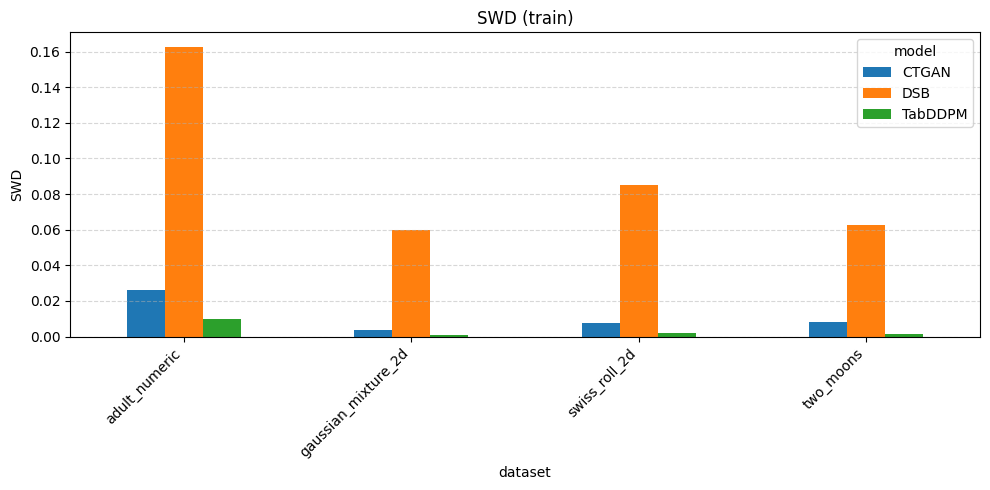

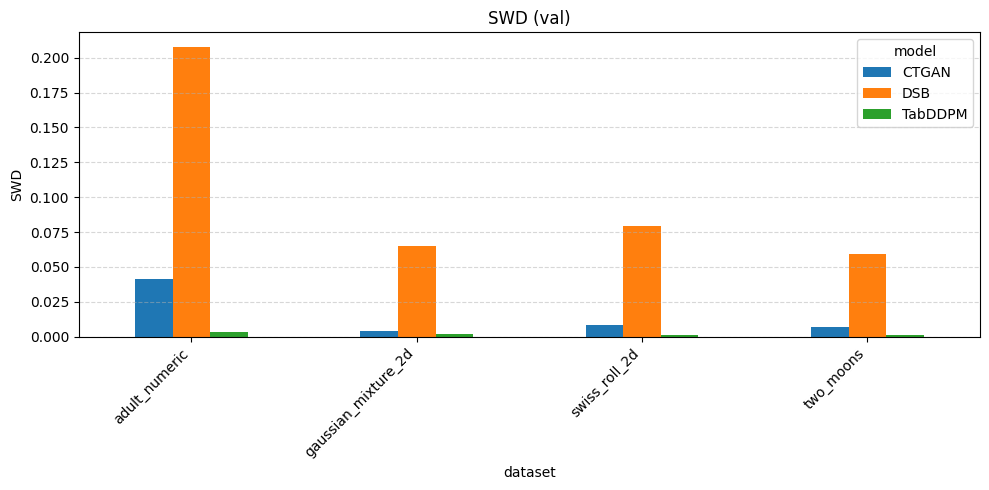

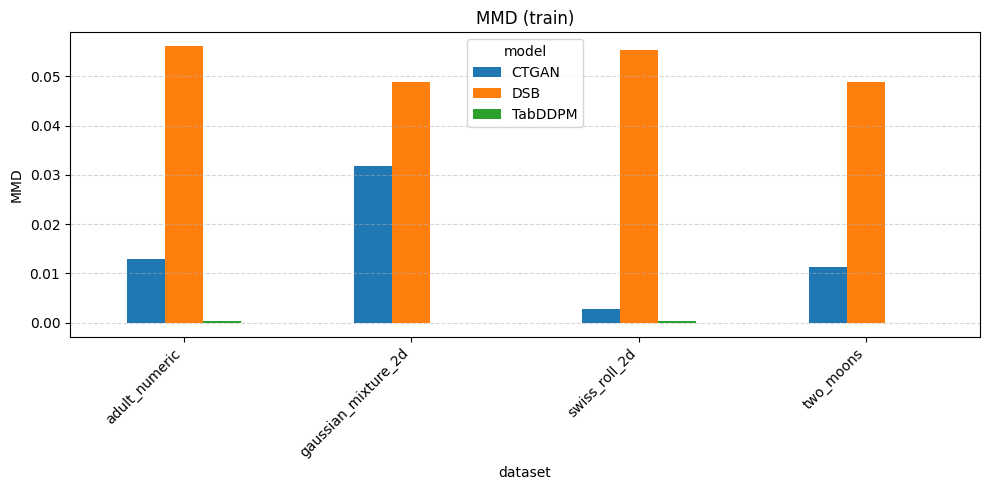

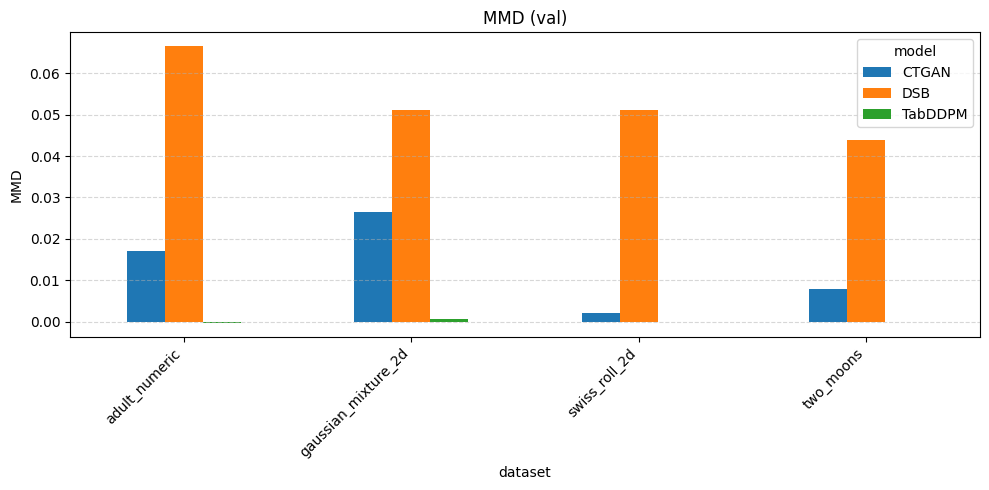

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- 1. Собираем метрики в таблицу -----------------

rows = []

for ds_name, models_dict in metrics_all.items():
    for model_name, vals in models_dict.items():
        # train
        rows.append({
            "dataset": ds_name,
            "model": model_name,
            "split": "train",
            "swd": float(vals["swd_train"]) if vals.get("swd_train") is not None else None,
            "mmd": float(vals["mmd_train"]) if vals.get("mmd_train") is not None else None,
        })
        # val (если есть)
        if vals.get("swd_val") is not None:
            rows.append({
                "dataset": ds_name,
                "model": model_name,
                "split": "val",
                "swd": float(vals["swd_val"]) if vals.get("swd_val") is not None else None,
                "mmd": float(vals["mmd_val"]) if vals.get("mmd_val") is not None else None,
            })

metrics_df = pd.DataFrame(rows)
print(metrics_df.head())

# ----------------- 2. Функция для построения barplot -----------------

def plot_metric_bar(df: pd.DataFrame, metric: str, split: str):
    df_split = df[df["split"] == split].copy()
    if df_split.empty:
        print(f"Нет данных для split='{split}'")
        return

    # pivot: строки — датасеты, столбцы — модели, значения — метрика
    pivot = df_split.pivot(index="dataset", columns="model", values=metric)

    ax = pivot.plot(kind="bar", figsize=(10, 5))
    ax.set_ylabel(metric.upper())
    ax.set_title(f"{metric.upper()} ({split})")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# ----------------- 3. Строим графики -----------------

# SWD: train и val
plot_metric_bar(metrics_df, metric="swd", split="train")
plot_metric_bar(metrics_df, metric="swd", split="val")

# MMD: train и val
plot_metric_bar(metrics_df, metric="mmd", split="train")
plot_metric_bar(metrics_df, metric="mmd", split="val")


In [6]:
import optuna

# у тебя в скрипте было:
# STORAGE = "sqlite:///optuna_tabular.db"
storage_url = "sqlite:///optuna_tabular.db"

# посмотреть все стадии
studies = optuna.study.get_all_study_summaries(storage=storage_url)
for s in studies:
    print(f"Study name: {s.study_name}, direction: {s.direction}, trials: {s.n_trials}")

# открыть конкретную стадию
study_name = "CTGAN_adult_numeric"  # пример имени, подставь своё
study = optuna.load_study(study_name=study_name, storage=storage_url)

print("Best value:", study.best_value)
print("Best params:", study.best_params)

# пробежать по триалам и посмотреть их значения/атрибуты
for t in study.trials:
    print(
        f"trial {t.number}: value={t.value}, "
        f"swd_val={t.user_attrs.get('swd_val')}, "
        f"mmd_val={t.user_attrs.get('mmd_val')}"
    )


Study name: DSB_adult_numeric, direction: 1, trials: 22
Study name: CTGAN_adult_numeric, direction: 1, trials: 1


ValueError: Record does not exist.

In [10]:
import optuna
from optuna.trial import TrialState

storage_url = "sqlite:///optuna_tabular.db"

# 1. Список всех стадий
summaries = optuna.study.get_all_study_summaries(storage=storage_url)
print("Studies in DB:")
for s in summaries:
    if s.best_trial is not None:
        print(
            f"- {s.study_name}, "
            f"n_trials={s.n_trials}, "
            f"best_value={s.best_trial.value}"
        )
    else:
        print(
            f"- {s.study_name}, "
            f"n_trials={s.n_trials}, "
            f"best_value=None (no COMPLETED trials)"
        )


Studies in DB:
- DSB_adult_numeric, n_trials=22, best_value=0.049741074442863464
- CTGAN_adult_numeric, n_trials=2, best_value=None (no COMPLETED trials)


In [12]:
study_name = "DSB_adult_numeric"  # подставь то, что увидишь в списке выше
study = optuna.load_study(study_name=study_name, storage=storage_url)

print("Total trials:", len(study.trials))
print("States:", [t.state for t in study.trials])

completed = [t for t in study.trials if t.state == TrialState.COMPLETE]
if not completed:
    print("No COMPLETED trials in this study.")
else:
    best = study.best_trial
    print("Best value:", best.value)
    print("Best params:", best.params)
    print("swd_val:", best.user_attrs.get("swd_val"))
    print("mmd_val:", best.user_attrs.get("mmd_val"))


Total trials: 22
States: [<TrialState.FAIL: 3>, <TrialState.FAIL: 3>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>, <TrialState.COMPLETE: 1>]
Best value: 0.049741074442863464
Best params: {'N': 24, 'alpha_ou': 0.325535603677596, 'lr': 0.0004560904713879292, 'hidden': 128, 'time_features': 8, 'ipf_iters': 2, 'steps_B': 101, 'steps_F': 199, 'batch': 1559}
swd_val: 0.056512631475925446
mmd_val: 0.013003945350646973


In [2]:
import optuna
from optuna.trial import TrialState

# если у тебя другой путь/имя файла — поправь строку ниже
STORAGE_URL = "sqlite:///optuna_tabular.db"

def main():
    # Получаем список всех стадий в базе
    summaries = optuna.study.get_all_study_summaries(storage=STORAGE_URL)

    print("Studies in DB:")
    for s in summaries:
        print(f"- {s.study_name}, n_trials={s.n_trials}")

    print("\n=== CTGAN studies ===")
    for s in summaries:
        if not s.study_name.startswith("CTGAN_"):
            continue

        study_name = s.study_name
        print(f"\n===== Study: {study_name} =====")

        study = optuna.load_study(study_name=study_name, storage=STORAGE_URL)

        print(f"Total trials: {len(study.trials)}")

        for t in study.trials:
            # t.state: COMPLETE, FAIL, PRUNED и т.д.
            state = t.state

            # value может быть None, если trial упал/прерван
            value = t.value

            print(f"\nTrial #{t.number}")
            print(f"  state: {state}")
            print(f"  value: {value}")

            # Параметры trial’а
            if t.params:
                print("  params:")
                for k, v in t.params.items():
                    print(f"    {k}: {v}")
            else:
                print("  params: <none>")

            # Если ты сохранял SWD/MMD в user_attrs (как мы делали в objective)
            if t.user_attrs:
                print("  user_attrs:")
                for k, v in t.user_attrs.items():
                    print(f"    {k}: {v}")
            else:
                print("  user_attrs: <none>")

        # Также можно вывести best_trial, если он есть
        completed = [tr for tr in study.trials if tr.state == TrialState.COMPLETE]
        if completed:
            best = study.best_trial
            print("\n  >>> Best trial summary:")
            print(f"    number: {best.number}")
            print(f"    value:  {best.value}")
            print(f"    params: {best.params}")
        else:
            print("\n  >>> No COMPLETED trials in this study.")

if __name__ == "__main__":
    main()


Studies in DB:
- CTGAN_california_housing, n_trials=17
- CTGAN_king_county_housing, n_trials=20

=== CTGAN studies ===

===== Study: CTGAN_california_housing =====
Total trials: 17

Trial #0
  state: TrialState.COMPLETE
  value: 1.0213019472341474
  params:
    epochs: 119
    batch_size: 256
    embedding_dim: 256
    gen_width: 256
    disc_width: 256
    pac: 8
    generator_lr: 0.0004086485930834704
    discriminator_lr: 0.00023064456939168057
  user_attrs:
    corr_frobenius: 1.836256997958227
    corr_mae_offdiag: 0.1368017188379422
    ks_mean: 0.13962572674418605
    mmd_val: 0.044763922691345215
    swd_val: 0.32560956478118896
    wd_mean: 0.1908753143836623

Trial #1
  state: TrialState.FAIL
  value: None
  params:
    epochs: 358
    batch_size: 1024
    embedding_dim: 256
    gen_width: 256
    disc_width: 128
    pac: 8
    generator_lr: 0.0004406789776996634
    discriminator_lr: 0.00012127210383135234
  user_attrs: <none>

Trial #2
  state: TrialState.COMPLETE
  value: 

In [3]:
import optuna
from optuna.trial import TrialState

# если у тебя другой путь/имя файла — поправь строку ниже
STORAGE_URL = "sqlite:///optuna_tabular.db"

def main():
    # Получаем список всех стадий в базе
    summaries = optuna.study.get_all_study_summaries(storage=STORAGE_URL)

    print("Studies in DB:")
    for s in summaries:
        print(f"- {s.study_name}, n_trials={s.n_trials}")

    print("\n=== TABDDPM_ studies ===")
    for s in summaries:
        if not s.study_name.startswith("TABDDPM_"):
            continue

        study_name = s.study_name
        print(f"\n===== Study: {study_name} =====")

        study = optuna.load_study(study_name=study_name, storage=STORAGE_URL)

        print(f"Total trials: {len(study.trials)}")

        for t in study.trials:
            # t.state: COMPLETE, FAIL, PRUNED и т.д.
            state = t.state

            # value может быть None, если trial упал/прерван
            value = t.value

            print(f"\nTrial #{t.number}")
            print(f"  state: {state}")
            print(f"  value: {value}")

            # Параметры trial’а
            if t.params:
                print("  params:")
                for k, v in t.params.items():
                    print(f"    {k}: {v}")
            else:
                print("  params: <none>")

            # Если ты сохранял SWD/MMD в user_attrs (как мы делали в objective)
            if t.user_attrs:
                print("  user_attrs:")
                for k, v in t.user_attrs.items():
                    print(f"    {k}: {v}")
            else:
                print("  user_attrs: <none>")

        # Также можно вывести best_trial, если он есть
        completed = [tr for tr in study.trials if tr.state == TrialState.COMPLETE]
        if completed:
            best = study.best_trial
            print("\n  >>> Best trial summary:")
            print(f"    number: {best.number}")
            print(f"    value:  {best.value}")
            print(f"    params: {best.params}")
        else:
            print("\n  >>> No COMPLETED trials in this study.")

if __name__ == "__main__":
    main()


Studies in DB:
- TABDDPM_california_housing, n_trials=2

=== TABDDPM_ studies ===

===== Study: TABDDPM_california_housing =====
Total trials: 2

Trial #0
  state: TrialState.COMPLETE
  value: 162.0591208934784
  params:
    n_iter: 82
    num_timesteps: 335
    model_type: tabnet
    sampling_patience: 339
  user_attrs:
    mmd_val: 0.10333824902772903
    swd_val: 147.79368591308594

Trial #1
  state: TrialState.FAIL
  value: None
  params:
    n_iter: 200
    num_timesteps: 542
    model_type: tabnet
    sampling_patience: 286
  user_attrs: <none>

  >>> Best trial summary:
    number: 0
    value:  162.0591208934784
    params: {'n_iter': 82, 'num_timesteps': 335, 'model_type': 'tabnet', 'sampling_patience': 339}


# Смотрим на данные

In [7]:
!pip install ucimlrepo


In [ ]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.datasets import (
    fetch_california_housing,
    load_diabetes,
    fetch_kddcup99,
    fetch_openml,
)

# ---------- 1. California Housing (sklearn) ----------
cal = fetch_california_housing(as_frame=True)  # sklearn встроенный датасет :contentReference[oaicite:0]{index=0}
df_cal = cal.frame  # features + target 'MedHouseVal'
print("California Housing:", df_cal.shape)
display(df_cal.head())

# если нужно только X как np.ndarray (только фичи):
X_cal = df_cal.drop(columns=["MedHouseVal"]).to_numpy(dtype=np.float32)

# ---------- 2. Diabetes (sklearn) ----------
dia = load_diabetes(as_frame=True)  # 10 числовых фич, регрессия :contentReference[oaicite:1]{index=1}
df_dia = dia.frame   # features + target 'target'
print("Diabetes:", df_dia.shape)
display(df_dia.head())

X_dia = df_dia.drop(columns=["target"]).to_numpy(dtype=np.float32)

# ---------- 3. Online News Popularity (UCI) ----------
# Официальный UCI-датасет, 39797 строк, 58 фич + url + target shares :contentReference[oaicite:2]{index=2}
onp = fetch_ucirepo(id=332)

# onp.data.features и onp.data.targets — уже pandas.DataFrame
df_news_raw = pd.concat(
    [onp.data.features, onp.data.targets],
    axis=1
)

print("Online News Popularity (raw):", df_news_raw.shape)
display(df_news_raw.head())

# по описанию:
#   - 'url' — непредиктивный ID, дропаем
#   - 'shares' — таргет

# чисто фичи без таргета
X_news = df_news_raw

# ---------- 4. King County Housing (OpenML house_sales id=42092) ----------
# OpenML датасет: house sale prices for King County :contentReference[oaicite:3]{index=3}
kc = fetch_openml(data_id=42092, as_frame=True)  # 'house_sales'
df_kc_raw = kc.frame  # включает price (target) + признаки
print("King County Housing (raw):", df_kc_raw.shape)
display(df_kc_raw.head())

# Обычно:
#   - 'price' — target
#   - 'id' — ID
#   - 'date' — строка, её дропаем для чисто числового X
drop_cols_kc = [c for c in ["price", "id", "date"] if c in df_kc_raw.columns]
df_kc = df_kc_raw.drop(columns=drop_cols_kc)
print("King County Housing (numeric-only after drops):", df_kc.shape)
print(df_kc.dtypes.value_counts())

X_kc = df_kc.select_dtypes(include=["number"]).to_numpy(dtype=np.float32)

# ---------- 5. Loan (Bank_Personal_Loan_Modelling, Kaggle) ----------
LOAN_XLSX_PATH = "data/Bank_Personal_Loan_Modelling.xlsx"  # путь к скачанному xlsx

# во многих ноутбуках используют второй лист (index=1); если будет ошибка — поменяй на 0
df_loan_raw = pd.read_excel(LOAN_XLSX_PATH, sheet_name=1)
print("Loan raw shape:", df_loan_raw.shape)
print("Loan dtypes:")
print(df_loan_raw.dtypes.value_counts())

# дропаем явно нерелевантные/ID-поля
drop_cols_loan = [c for c in ["ID", "ZIP Code"] if c in df_loan_raw.columns]
df_loan = df_loan_raw.drop(columns=drop_cols_loan)

# дропаем таргет (Personal Loan), ищем название чуть более робастно
target_col = None
for c in df_loan.columns:
    key = c.strip().lower().replace(" ", "")
    if key in ["personalloan"]:
        target_col = c
        break

if target_col is not None:
    df_loan = df_loan.drop(columns=[target_col])

# оставляем только числовые фичи
df_loan_num = df_loan.select_dtypes(include=["number"])
X_loan = df_loan_num.to_numpy(dtype=np.float32)

print("Loan numeric shape:", X_loan.shape)
# ---------- Соберём всё в один словарь для дальнейших экспериментов ----------

datasets_numeric = {
    "california_housing": X_cal,
    "diabetes": X_dia,
    "online_news_popularity": X_news,
    "king_county_housing": X_kc,
    "adult_numeric": X_loan,
}



California Housing: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Diabetes: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


Online News Popularity (raw): (39644, 59)


,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


King County Housing (raw): (21613, 20)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


King County Housing (numeric-only after drops): (21613, 18)
int64       13
float64      4
category     1
Name: count, dtype: int64
Loan raw shape: (5000, 14)
Loan dtypes:
int64      13
float64     1
Name: count, dtype: int64
Loan numeric shape: (5000, 11)
california_housing        -> shape=(20640, 8), dtype=float32
diabetes                  -> shape=(442, 10), dtype=float32


AttributeError: 'DataFrame' object has no attribute 'dtype'

In [21]:
import pickle

with open("datasets_numeric.pkl", "wb") as f:
    pickle.dump(datasets_numeric, f)


In [23]:
with open("datasets_numeric.pkl", "rb") as f:
    datasets_numeric = pickle.load(f)

for name, X in datasets_numeric.items():
    print(f"{name:25s} -> shape={X.shape}, ")


california_housing        -> shape=(20640, 8), 
diabetes                  -> shape=(442, 10), 
online_news_popularity    -> shape=(39644, 59), 
king_county_housing       -> shape=(21613, 17), 
adult_numeric             -> shape=(5000, 11), 


In [3]:
import pandas as pd
LOAN_XLSX_PATH = "data/Bank_Personal_Loan_Modelling.xlsx"  # путь к скачанному xlsx

# во многих ноутбуках используют второй лист (index=1); если будет ошибка — поменяй на 0
df_loan_raw = pd.read_excel(LOAN_XLSX_PATH, sheet_name=1)
print("Loan raw shape:", df_loan_raw.shape)
print("Loan dtypes:")
print(df_loan_raw.dtypes.value_counts())

# дропаем явно нерелевантные/ID-поля
drop_cols_loan = [c for c in ["ID", "ZIP Code"] if c in df_loan_raw.columns]
df_loan = df_loan_raw.drop(columns=drop_cols_loan)


# дропаем таргет (Personal Loan), ищем название чуть более робастно
target_col = None
for c in df_loan.columns:
    key = c.strip().lower().replace(" ", "")
    if key in ["personalloan"]:
        target_col = c
        break

if target_col is not None:
    df_loan = df_loan.drop(columns=[target_col])

# оставляем только числовые фичи
df_loan_num = df_loan.select_dtypes(include=["number"])
df_loan_num

Loan raw shape: (5000, 14)
Loan dtypes:
int64      13
float64     1
Name: count, dtype: int64


,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,1,0,0,0
1,45,19,34,3,1.5,1,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,3,0,0,0,1,0
4996,30,4,15,4,0.4,1,85,0,0,1,0
4997,63,39,24,2,0.3,3,0,0,0,0,0
4998,65,40,49,3,0.5,2,0,0,0,1,0
